In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import argparse
from matplotlib.patches import ConnectionPatch
import unicodedata
import re

In [27]:
df = pd.read_csv('./response.csv', sep=',', engine="python", encoding='utf-8')

In [28]:
def normalizar(df):
    coluna_pattern="institu"
    colunas = [col for col in df.columns if coluna_pattern.lower() in col.lower()]
    if not colunas:
        raise ValueError(f"Nenhuma coluna encontrada com padrão '{coluna_pattern}' no nome das colunas: {df.columns.tolist()}")
    coluna_alvo = colunas[0]
    mask = (
        df[coluna_alvo].str.contains("IF", case=False, na=False) |
        df[coluna_alvo].str.contains("instituto federal catarinense", case=False, na=False)
    )
    df.loc[mask, coluna_alvo] = 'IFC'
    coluna_pattern="o seu curso "
    colunas = [col for col in df.columns if coluna_pattern.lower() in col.lower()]
    if not colunas:
        raise ValueError(f"Nenhuma coluna encontrada com padrão '{coluna_pattern}' no nome das colunas: {df.columns.tolist()}")
    coluna_alvo = colunas[0]
    mask = (
        df[coluna_alvo].str.contains("BCC", case=False, na=False) |
        df[coluna_alvo].str.contains("Computação", case=False, na=False)
    )
    df.loc[mask, coluna_alvo] = 'BCC'
    mask = (
        df[coluna_alvo].str.contains("Informática", case=False, na=False) |
        df[coluna_alvo].str.contains("técnico", case=False, na=False)
    )
    df.loc[mask, coluna_alvo] = 'Téc Info'
    mask = (
        df[coluna_alvo].str.contains("Software", case=False, na=False) 
    )
    df.loc[mask, coluna_alvo] = 'Eng de Soft'
    mask = (
        df[coluna_alvo].str.contains("informação", case=False, na=False) 
    )
    df.loc[mask, coluna_alvo] = 'Sist de Info'
    mask = (
        df[coluna_alvo].str.contains("web", case=False, na=False) 
    )
    df.loc[mask, coluna_alvo] = 'Dev Web'

    new = ['data', 'email', 'nome', 'instituicao', 'curso', 'trabalho', 'plataforma', 'perifericos', 'importancia', 'genero', 'influcencia', 'aplicacao', 'horas', 'investimento', 'fatores de compra']

    novo_nome_colunas = {col_antigo: col_novo for col_antigo, col_novo in zip(df.columns, new)}
    
    return df.rename(columns=novo_nome_colunas)

In [29]:
df_tratado = normalizar(df)

In [30]:
def plotChart(col, kind, df=df_tratado):
    if kind == 'pie-bar':
        proporcoes = df[col].value_counts(normalize=True)
        labels = proporcoes.index.tolist()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1]})
        fig.subplots_adjust(wspace=0.3)

        explode = [0.05] * len(labels)
        angle = -180 * proporcoes.iloc[0]
        wedges, *_ = ax1.pie(
            proporcoes,
            autopct='%1.1f%%',
            startangle=angle,
            labels=labels,
            explode=explode
        )
        ax1.set_title(f'Distribuição de {col} - Pizza')

        counts = proporcoes
        fig2, axb = ax2.get_figure(), ax2
        bottom = 0
        width = 0.6
        for height, label in zip(counts, labels):
            rects = axb.bar(0, height, width, bottom=bottom, label=label)
            axb.bar_label(rects, labels=[f'{height:.0%}'], label_type='center')
            bottom += height

        axb.set_title(f'Distribuição de {col} - Barras')
        axb.set_xlim(-width, width)
        axb.set_ylim(0, 1)
        axb.set_xticks([])
        axb.set_ylabel('Proporção')
        axb.legend()

        theta1, theta2 = wedges[0].theta1, wedges[0].theta2
        center, r = wedges[0].center, wedges[0].r

        x2, y2 = (
            r * np.cos(np.deg2rad(theta2)) + center[0],
            r * np.sin(np.deg2rad(theta2)) + center[1]
        )
        con1 = ConnectionPatch(
            xyA=(-width/2, 1), coordsA=axb.transData,
            xyB=(x2, y2), coordsB=ax1.transData,
            color='gray', linewidth=1
        )
        axb.add_artist(con1)

        x1, y1 = (
            r * np.cos(np.deg2rad(theta1)) + center[0],
            r * np.sin(np.deg2rad(theta1)) + center[1]
        )
        con2 = ConnectionPatch(
            xyA=(-width/2, 0), coordsA=axb.transData,
            xyB=(x1, y1), coordsB=ax1.transData,
            color='gray', linewidth=1
        )
        axb.add_artist(con2)

    elif kind == 'bartwo':
        counts = df[col].value_counts()
        fig, ax = plt.subplots(figsize=(8, 6))
        counts.plot(kind='barh', ax=ax)
        ax.set_title(f'Distribuição de {col}')
        ax.set_xlabel('Proporção')
        ax.set_ylabel('Categorias')
        plt.tight_layout()
    elif kind == 'pie':
        counts = df[col].value_counts()
        total = counts.sum()
        fig, ax = plt.subplots(figsize=(8, 8))
        wedges, texts, autotexts = ax.pie(
            counts,
            autopct=lambda pct: f"{int(pct * total / 100)} ({pct:.2f}%)",
            pctdistance=0.7,
            labeldistance=1.1,
            startangle=90,
            wedgeprops=dict(width=0.4)
        )
        ax.set_title(f'Distribuição de {col}')
        ax.set(aspect="equal")
        plt.tight_layout()
    elif kind == 'kde':
        plt.figure()
        df[col].plot(kind=kind)
        plt.title(f'Distribuição de {col}')
        plt.xlabel(col)
        plt.ylabel('Contagem')
        plt.xlim(1, 5)
    elif kind == 'density':
        plt.figure()
        df[col].plot(kind=kind)
        plt.title(f'Distribuição de {col}')
        plt.xlabel(col)
        plt.ylabel('Contagem')
    else:
        fig, ax = plt.subplots(figsize=(8, 6))
        df[col].plot(kind=kind, ax=ax)
        ax.set_title(f'Distribuição de {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Contagem')
        ymin, ymax = df[col].min(), df[col].max()
        yrange = ymax - ymin
        ax.set_ylim(ymin - 0.1 * yrange, ymax + 0.1 * yrange)
        plt.tight_layout
    plt.show()

In [31]:
def separar_registros(df, coluna, separador=';'):
    df[coluna] = df[coluna].str.split(separador)
    return df.explode(coluna).reset_index(drop=True)

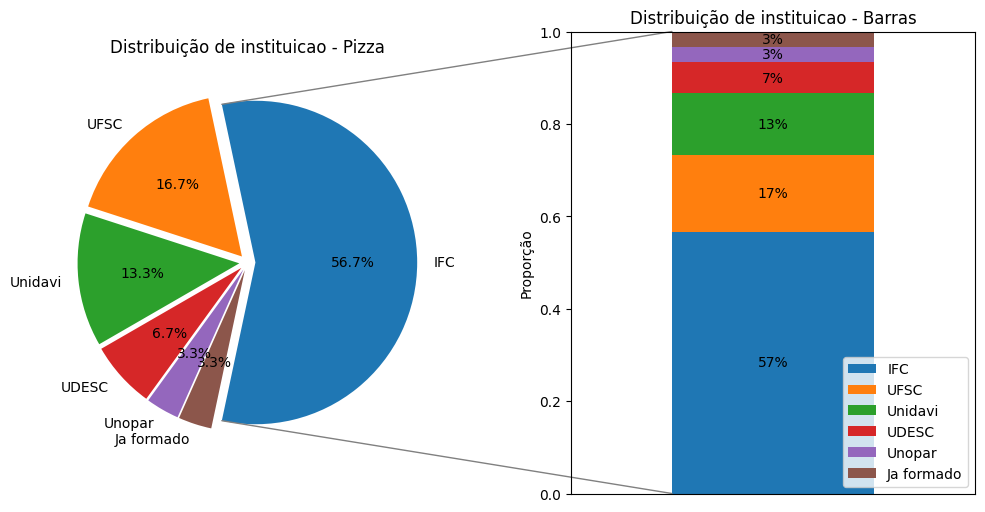

In [32]:
plotChart('instituicao', 'pie-bar', df_tratado)

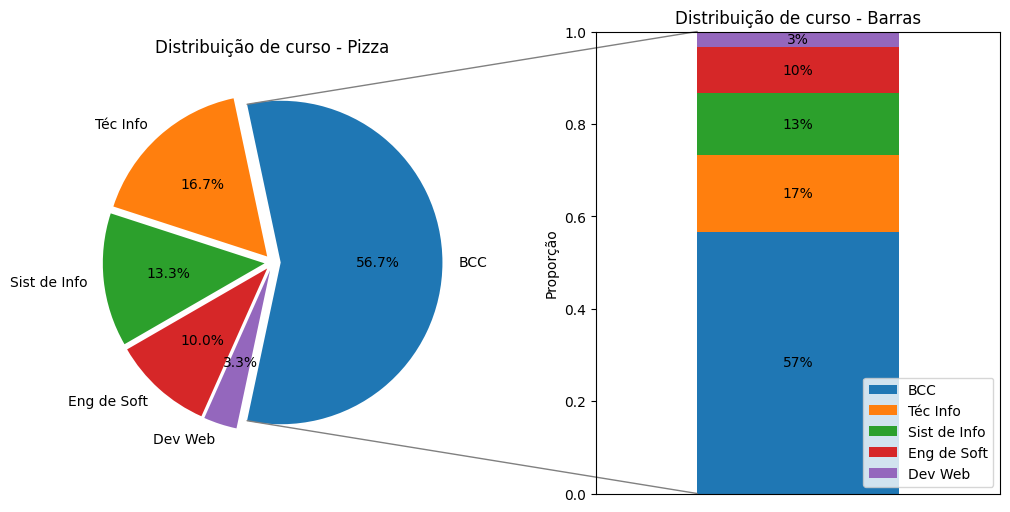

In [33]:
plotChart('curso', 'pie-bar', df_tratado)

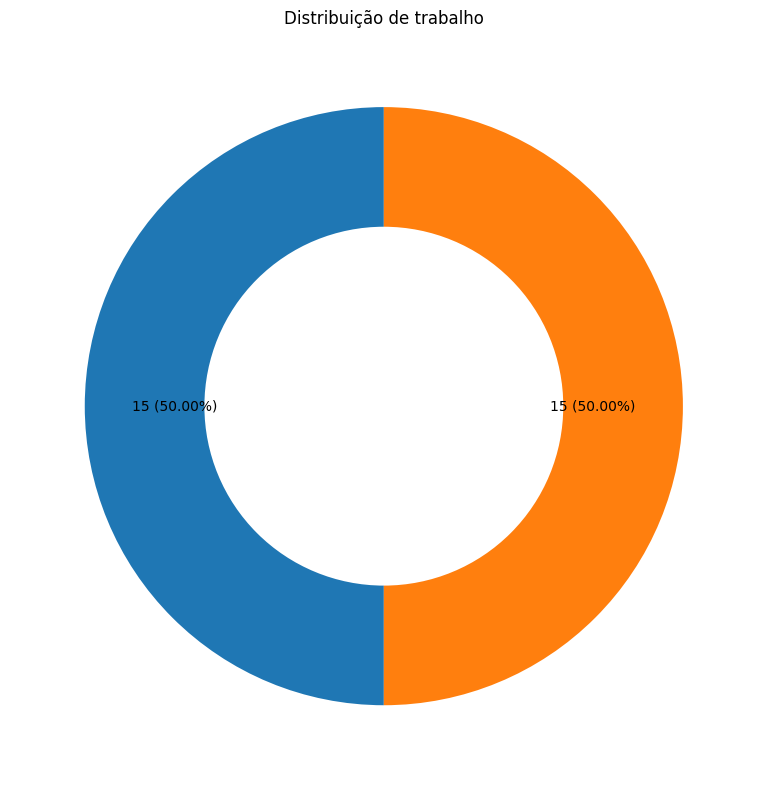

In [34]:
plotChart('trabalho', 'pie', df_tratado)

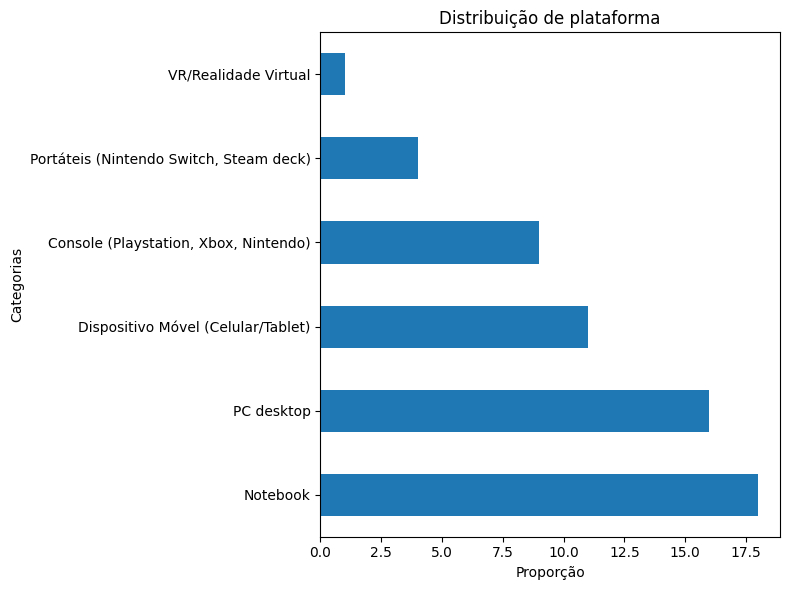

In [35]:
df_separado = separar_registros(df_tratado.copy(), 'plataforma')
plotChart('plataforma', 'bartwo', df_separado)

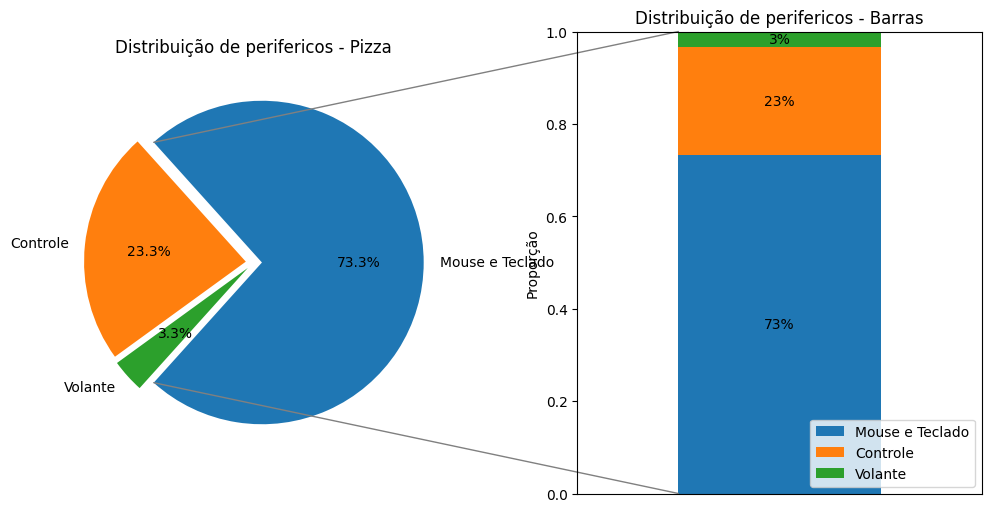

In [36]:
plotChart('perifericos', 'pie-bar', df_tratado)

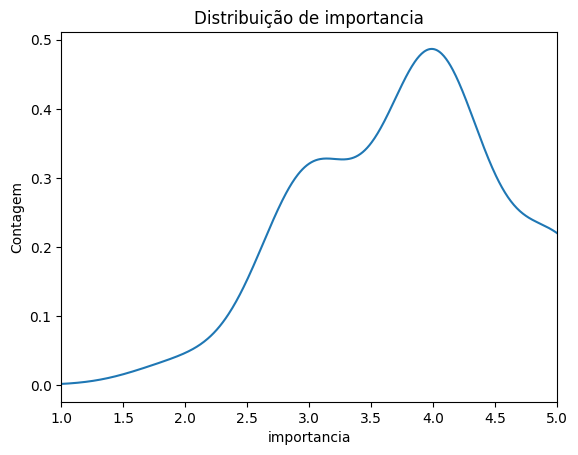

In [39]:
plotChart('importancia', 'kde', df_tratado)

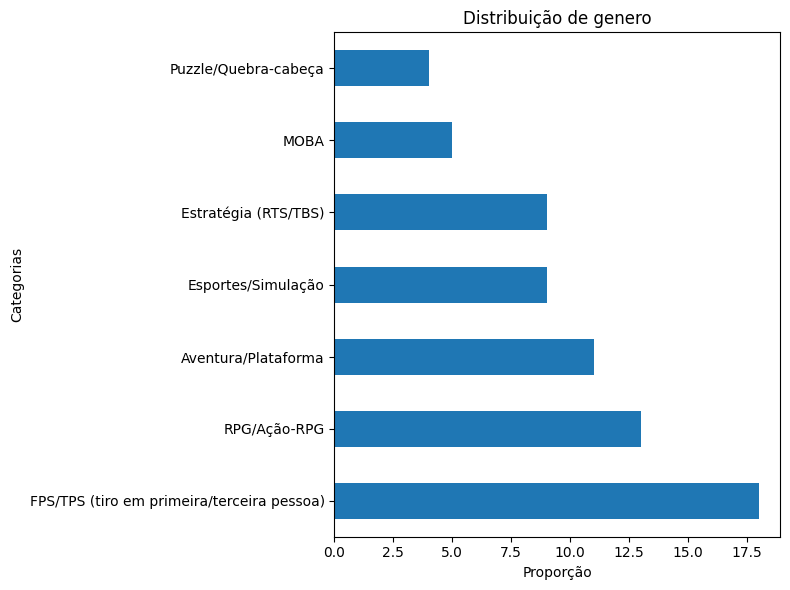

In [40]:
df_separado = separar_registros(df_tratado.copy(), 'genero')
plotChart('genero', 'bartwo', df_separado)

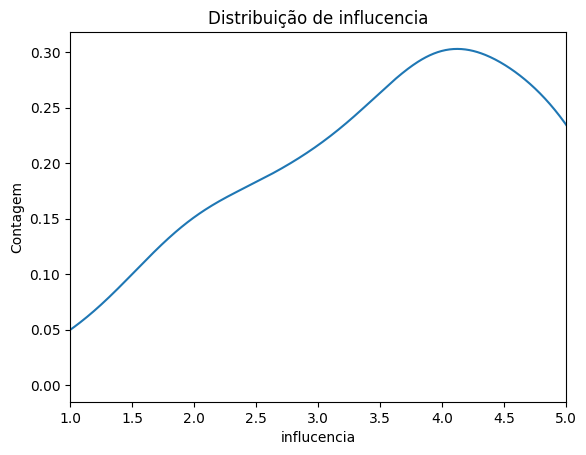

In [43]:
plotChart('influcencia', 'kde', df_tratado)

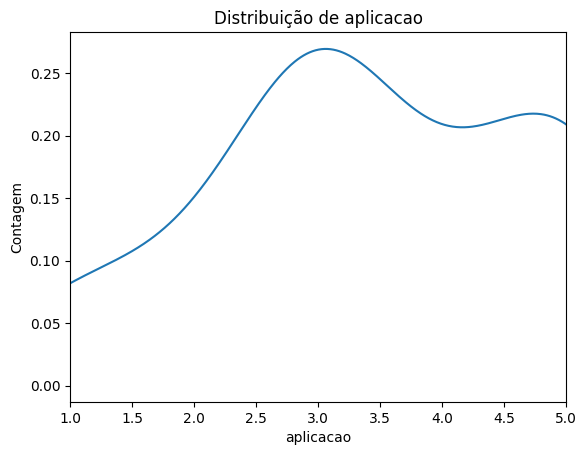

In [44]:
plotChart('aplicacao', 'kde', df_tratado)

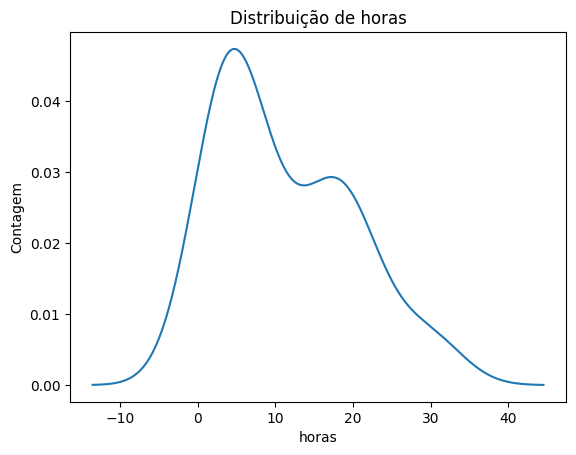

In [45]:
plotChart('horas', 'density', df_tratado)

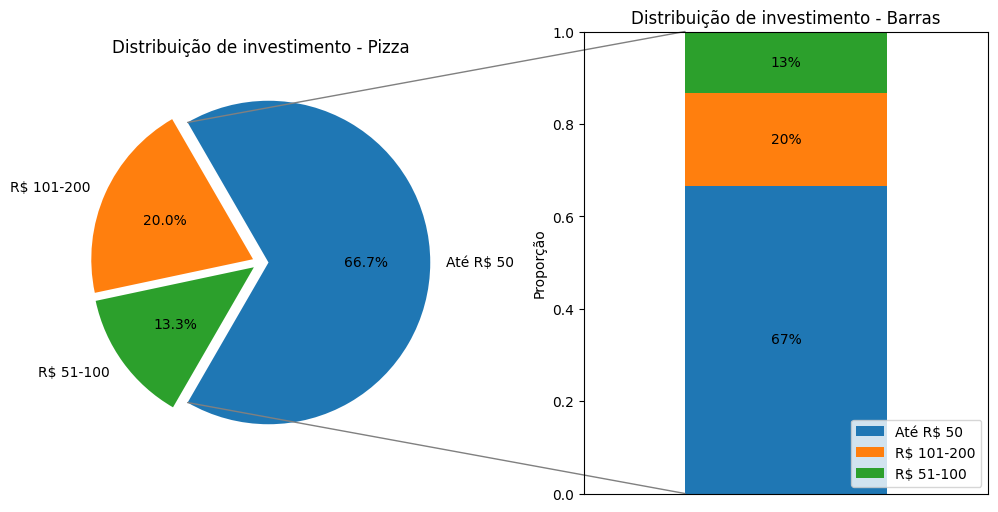

In [46]:
plotChart('investimento', 'pie-bar', df_tratado)

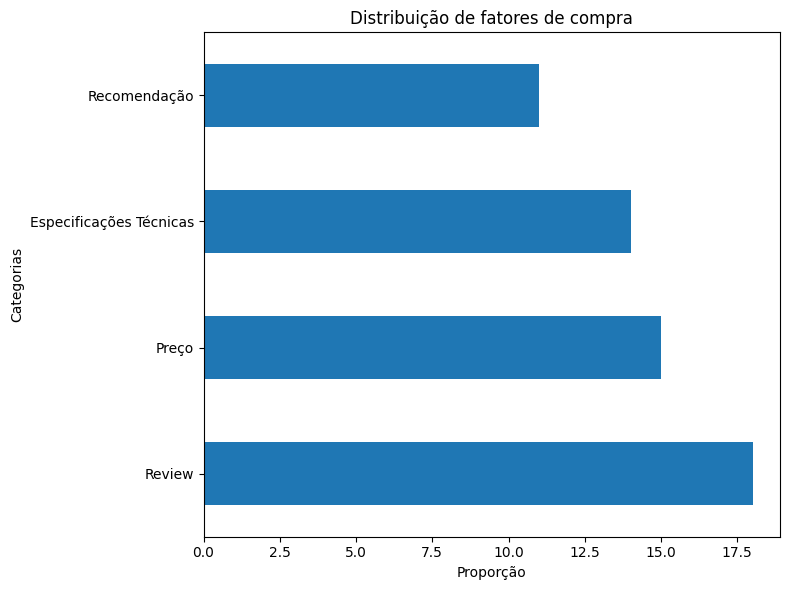

In [47]:
df_separado = separar_registros(df_tratado.copy(), 'fatores de compra')
plotChart('fatores de compra', 'bartwo', df_separado)

# Conclusão 

    A partir dos dados coletados junto a 30 estudantes de cursos de Informática e Computação, que são representados majoritariamente por estudantes do IFC, em específico do curso de Ciência da Computação, podemos chegar a algumas dicusssões e estipulações

## Predomínio de plataformas de uso geral
>Os notebooks (60 %) e desktops (53 %) são as plataformas mais adotadas (Gráfico Distribuição de Plataforma), o que sugere preferência por dispositivos que atendam simultaneamente às demandas acadêmicas e lúdicas desta população.

## Valorização de periféricos de precisão
>Mouse e teclado foram citados por 73 % dos participantes (Gráfico de Periféricos), e a importância média atribuída a periféricos de alta performance atingiu 3,83 em escala 1–5, indicando forte demanda por equipamentos que ofereçam resposta e durabilidade superiores (Gráfico de importância de periféricos).

## Gêneros que combinam técnica e imersão
>FPS/TPS lidera com 60 % de menções, seguido por RPG/Ação-RPG (43 %) e Aventura/Plataforma (37 %) (Gráfico de Gênero). Esses resultados refletem o interesse em jogos que exigem tanto habilidade motora quanto apreciação de narrativa e design técnico, que pode explicar a valorização de perriféricos de precisão, por tais gêneros.


## Influência da formação técnica
>A média de 3,57 na percepção de influência da formação em Informática/Computação sobre escolhas de hardware e software, e de 3,43 na aplicação prática de conhecimentos técnicos em benefício do jogo, confirmam o papel ativo da expertise acadêmica na personalização da experiência de jogo (Gráfico de Influência de Conhecimento Técnico).

## Limitação orçamentária e critérios de escolha
>Embora o tempo médio de jogo seja de 11,4 hora/semana, 67 % dos respondentes destinam até R$ 50 mensais a jogos e acessórios. Reviews (60 %) e preço (50 %) são os principais fatores de compra, seguidos por especificações técnicas (47 %) e recomendações (37 %) (Gráfico de Fatores de Compra), evidenciando sensibilidade ao custo-benefício aliada a necessidade de informação técnica qualificada.

    Em síntese, a formação em Informática e Computação não apenas molda as preferências de plataforma e gênero, mas também reforça a busca por periféricos de alto desempenho e por informações técnicas fundamentadas. Esses insights podem apoiar o desenvolvimento de produtos e serviços que equilibrem custo, qualidade técnica e conteúdo analítico, atendendo a um público tecnicamente exigente.